<a href="https://colab.research.google.com/github/Pumafi/VLG/blob/master/ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural network 

<div>
<img src="https://le-cdn.website-editor.net/4b5e1e3a4a364b689c2606ca8c78024d/dms3rep/multi/opt/Amptso-9ccb7a7a-f72ae4be-9277c828-640w.png" width="250"/>
</div>

Prepared by Nicolas Desassis from [Pytorch documentation](https://https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
)


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

In this notebook, we will work with the [CIFAR 10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

This dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


<div>
<img src="https://pytorch.org/tutorials/_images/cifar10.png" width="500"/>
</div>



In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

170498071/170498071 [==============================] - 40s 0us/step


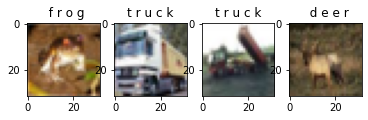

In [3]:
for i in range(4):
  plt.subplot(1, 4, i+1)
  # show images
  plt.imshow(x_train[i])
  # print labels
  plt.title(' '.join('%5s' % classes[tf.squeeze(y_train[i])]))

In [4]:
# Normalize the images
def normalize_resize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.divide(image, 255)
    # image = tf.image.resize(image, (28, 28))
    label = tf.keras.utils.to_categorical(tf.squeeze(label), num_classes = 10)
    return image, label

# This function can be used on our training set  for Data Augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    return image, label 

(x_train, y_train) = normalize_resize(x_train, y_train)
(x_test, y_test) = normalize_resize(x_test, y_test)

In [5]:
class DataLoader(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size=4, dim=(32, 32, 3), shuffle=True):
        self.x_data = x_data.numpy()
        self.y_data = y_data
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.x_data) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            shuffler = np.random.permutation(len(self.x_data))
            self.datax = self.x_data[shuffler]
            self.datay = self.y_data[shuffler]

    def __getitem__(self, index):
        X = self.x_data[index * self.batch_size:(index + 1) * self.batch_size]
        Y = self.y_data[index * self.batch_size:(index + 1) * self.batch_size]
        return X, Y


In [6]:
dataloader = DataLoader(x_train, y_train)
# Will return tuples of [batchsize, 32, 32, 3]

#The model

The different parameters of the convolution are explained at this [link](https://github.com/vdumoulin/conv_arithmetic).

We reproduce here their animations by focusing on what is useful for the rest of the notebook. 

Blue maps are inputs, and cyan maps are outputs. 

<div>
<img src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides.gif?raw=true" width="100"/><figcaption><b> 2d convolution with stride = 1 and padding = 0 (valid)<b/></figcaption>
</div>



<div>
<img src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/same_padding_no_strides.gif?raw=true" width="100"/><figcaption><b> 2d convolution with stride = 1 and padding of 1
 which ensurs that the output image as the same size than the input with a 3 x 3 kernel<b/></figcaption>
</div>



**Model**


In [7]:
class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional Layers

        self.conv_1 = tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                                             strides=(1, 1), padding='valid', activation='relu')

        self.conv_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu')

        # Maxpooling layer

        self.pool = tf.keras.layers.MaxPool2D(pool_size=2)

        self.flat = tf.keras.layers.Flatten()

        self.fc1 = tf.keras.layers.Dense(120, activation='relu')
        self.fc2 = tf.keras.layers.Dense(84, activation='relu')
        self.fc3 = tf.keras.layers.Dense(10, activation='softmax')
    
    def call(self, inputs):
        y = self.conv_1(inputs)
        y = self.pool(y)
        y = self.conv_2(y)
        y = self.flat(y)
        y = self.fc1(y)
        y = self.fc2(y)
        y = self.fc3(y)
        return y

In [8]:
net = Net()
net.build([None, 32, 32, 3])

In [9]:
net.summary()

Model: "net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1216      
                                                                 
 conv2d_1 (Conv2D)           multiple                  12832     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  384120    
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                               

In [10]:
criterion =  tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.5, beta_2=0.99)

In [ ]:
from tqdm import tqdm

for epoch in range(20): 
    running_loss = 0.0
    # We enumerate over the dataset, but call tqdm over that enumeration to get 
    # a pretty loading bar
    pbar = tqdm(enumerate(dataloader))
    for i, data in pbar:
        inputs, labels = data[0], data[1]
        # Enter the gradient recording phase
        with tf.GradientTape() as tape:
            outputs = net(inputs)
            loss = criterion(labels, outputs)
        gradients = tape.gradient(loss, net.trainable_variables)
        # Apply gradients
        optimizer.apply_gradients(zip(gradients, net.trainable_variables))

        running_loss += loss.numpy()
        if i % 10000 == 9999:    # print every 10000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10000))
            running_loss = 0.0

        pbar.set_postfix({'loss': loss.numpy()})
        
print('Finished Training')

In [12]:
dataloader = DataLoader(x_test, y_test)
for i, data in enumerate(dataloader):
    inputs, labels = data[0], np.argmax(data[1], axis=-1)
    

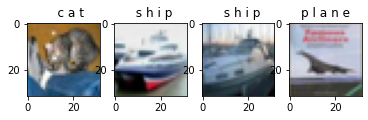

In [29]:
data = dataloader.__getitem__(0)
for i in range(4):
    plt.subplot(1, 4, i+1)
    inputs, labels = data[0], np.argmax(data[1], axis=-1)
    plt.imshow(inputs[i])
    plt.title(' '.join('%5s' % classes[tf.squeeze(labels[i])]))


(4,)


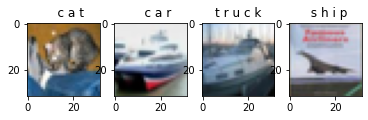

In [26]:
inputs, labels = data[0], np.argmax(data[1], axis=-1)
predicted_labels = net(inputs)
predicted_labels = np.argmax(predicted_labels, axis=-1)

for i in range(4):
    plt.subplot(1, 4, i+1)
    inputs, _ = data[0], np.argmax(data[1], axis=-1)
    plt.imshow(inputs[i])
    plt.title(' '.join('%5s' % classes[tf.squeeze(predicted_labels[i])]))

In [31]:
correct = 0
total = 0

for data in dataloader:
    images, labels = data
    inputs, labels = data[0], np.argmax(data[1], axis=-1)

    outputs = net(inputs)
    predicted = np.argmax(outputs, axis=-1)
    total += labels.shape[0]
    ########################
    #Your code Here
    correct += # How do we conmpute the amount of errors ?
    ########################

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 43 %


In [33]:
confusion = np.zeros((10,10)).astype(int)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in dataloader:
    images, labels = data
    inputs, labels = data[0], np.argmax(data[1], axis=-1)

    outputs = net(inputs)
    predicted = np.argmax(outputs, axis=-1)
    correct = (predicted == labels)

    for i in range(4):
        label = labels[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        confusion[labels[i], predicted[i]] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 44 %
Accuracy of   car : 45 %
Accuracy of  bird : 25 %
Accuracy of   cat : 36 %
Accuracy of  deer : 42 %
Accuracy of   dog :  9 %
Accuracy of  frog : 55 %
Accuracy of horse : 72 %
Accuracy of  ship : 57 %
Accuracy of truck : 48 %


### Confusion matrix

The lines indicate the true label, the columns indicate the predicted label.

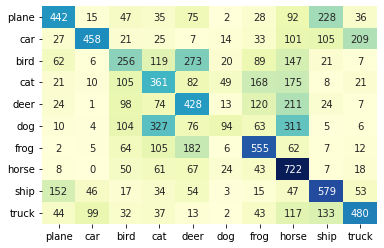

In [34]:
import seaborn as sns
sns.heatmap(confusion,cmap="YlGnBu", annot=True, fmt=".4g",cbar=False,xticklabels=classes, yticklabels=classes)

## Display the weights

### Weights of the first layer

We can access a layer of a model in keras using the following syntax :

model.layers[index_of_layer]

This return a Layer object, on which we can call get_weights() to return a tuple (kernel, bias)

In [42]:
def show_conv_kernel(weights):
    for i in range(weights.shape[2]):
        plt.figure(figsize=(50, 120))
        kernel_shape = weights.shape[-1]
        for j in range(kernel_shape):
          plt.subplot(1, kernel_shape, j+1)
          plt.axis('off')
          plt.imshow(weights[:, :, i, j], cmap='gray_r')
        plt.show()

In [ ]:
# Access the First layer weight
weights, biases = # Your code here
show_conv_kernel(weights)

### Weights of the second layer

In [ ]:
# Access the Second layer weights
weights, biases = # Your code here
show_conv_kernel(weights)

## Display the feature maps after each layer

We recall the forward function which show the different layer

```
    def call(self, inputs):
        y = self.conv_1(inputs)
        y = self.pool(y)
        y = self.conv_2(y)
        y = self.flat(y)
        y = self.fc1(y)
        y = self.fc2(y)
        y = self.fc3(y)
        return y
```

Since we can access the layer separately, we can use separately. This allow us to check the outputs at each levels. Let's test that.


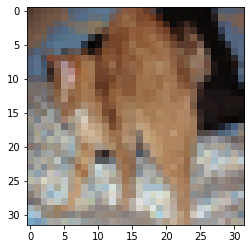

In [45]:
inputs, labels = data[0], np.argmax(data[1], axis=-1)
predicted_labels = net(inputs)
predicted_labels = np.argmax(predicted_labels, axis=-1)

img = inputs[0]
plt.imshow(img)
# Don't mind that img_extended, it's add a single dimension (batche dim) to our image
img_extended = tf.expand_dims(img, axis=0)

In [60]:
def show_activation_maps(activation_maps):
    maps = tf.squeeze(activation_maps)
    nb_channels = maps.shape[-1]
    plt.figure(figsize=(70, 200))
    for channel in range(nb_channels):
          plt.subplot(1, nb_channels, channel+1)
          plt.imshow(maps[:, :, channel], cmap='gray_r')
    plt.show()

In [ ]:
# Call the first layer on the image
activations_fst_layer = # You code here
show_activation_maps(activations_fst_layer)

In [ ]:
# Call the second layer
activations_snd_layer = # Your code here
show_activation_maps(activations_snd_layer)